In [1]:
import pycorr
# import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmos
from astropy import units as u
from astropy.io import fits
from sklearn.neighbors import KDTree
from data_process import jackknife_label
h = cosmos.H0.value/100

In [2]:
quasar = np.load('../catalogue/quasar_lss_all.npy')
random = np.load('../catalogue/random_quasar_lss_all.npy')

In [3]:
npix = jackknife_label(quasar, 10)
npix_r = jackknife_label(random, 10)
pix = np.unique(npix)

In [8]:
with open('label.bin', 'rb') as f:
    npix = np.load(f)
    npix_r = np.load(f)
pix = np.unique(npix)

In [4]:
label = np.zeros_like(npix)
label_r = np.zeros_like(npix_r)
all_pix = np.unique(npix)
for i, p in enumerate(all_pix):
    label[npix==p] = i
    label_r[npix_r==p] = i

In [31]:
dis_cov_q = cosmos.comoving_distance(quasar['z']).to(u.Mpc).value*h
dis_cov_r = cosmos.comoving_distance(random['z']).to(u.Mpc).value*h

In [32]:
import astropy.units as u
from astropy.cosmology import Planck18 as cosmos
import astropy.coordinates as coo
h = cosmos.H0.value/100

Nbins = 15
rp_bin = np.geomspace(3, 100, Nbins+1)
pimax = 100

In [ ]:
pos_q = np.vstack([quasar['ra'], quasar['dec'], dis_cov_q])
pos_r = np.vstack([random['ra'], random['dec'], dis_cov_r])
correlation_func = pycorr.correlation_function.TwoPointCorrelationFunction(
    'rp', rp_bin,
    pos_q, pos_q, pos_r, pos_r, 
    data_weights1=quasar['w'],
    data_weights2=quasar['w'],
    data_samples1=label,
    data_samples2=label,
    randoms_samples1=label_r,
    randoms_samples2=label_r,
    randoms_weights1=random['w'],
    randoms_weights2=random['w'],
    estimator='landyszalay',
    position_type='rdd'
)

In [33]:
pos_q = np.vstack([quasar['ra'], quasar['dec'], dis_cov_q])
pos_r = np.vstack([random['ra'], random['dec'], dis_cov_r])
correlation_func = pycorr.correlation_function.TwoPointCorrelationFunction(
    'rppi', (rp_bin, np.linspace(-pimax, pimax, 2*pimax+1, endpoint=True)),
    pos_q, pos_q, pos_r, pos_r, 
    data_weights1=quasar['w'],
    data_weights2=quasar['w'],
    data_samples1=label,
    data_samples2=label,
    randoms_samples1=label_r,
    randoms_samples2=label_r,
    randoms_weights1=random['w'],
    randoms_weights2=random['w'],
    estimator='landyszalay',
    position_type='rdd'
)

In [5]:
import pickle
with open('pycorr_1h.bin', 'rb') as f:
    correlation_func = pickle.load(f)

In [6]:
corr = correlation_func.get_corr(return_sep=True, return_cov=True)

In [7]:
rp, pi, xi, cov = corr

In [8]:
wp = xi.sum(axis=1)

In [10]:
stacked_cov = np.zeros((len(wp), len(wp)))
for i in range(len(wp)):
    for j in range(len(wp)):
        stacked_cov[i,j] = np.sum(cov[i*200:(i+1)*200, j*200:(j+1)*200])

In [11]:
std = np.sqrt([stacked_cov[i, i] for i in range(len(wp))])

In [14]:
cov_normed = stacked_cov / (std.reshape((-1, 1)) @ std.reshape((1, -1)))

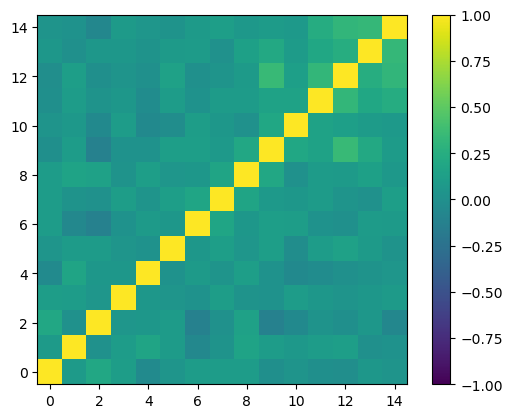

In [16]:
plt.imshow(cov_normed, origin='lower', vmin=-1, vmax=1)
plt.colorbar()

[]

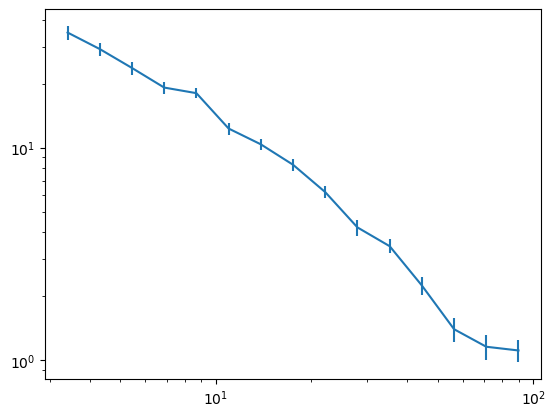

In [22]:
plt.errorbar(rp, wp, std)
plt.loglog()

In [10]:
import matplotlib.pyplot as plt

In [14]:
cov.max()

0.04134428597832792

In [17]:
xi

array([[-0.15747375,  0.11786572,  0.19798892, ...,  0.19798892,
         0.11786572, -0.15747375],
       [ 0.08982851, -0.03720555, -0.04361187, ..., -0.04361187,
        -0.03720555,  0.08982851],
       [ 0.03578898, -0.04809363, -0.05253313, ..., -0.05253313,
        -0.04809363,  0.03578898],
       ...,
       [-0.00845813,  0.00824025, -0.00650525, ..., -0.00650525,
         0.00824025, -0.00845813],
       [-0.004743  , -0.00365085, -0.00888721, ..., -0.00888721,
        -0.00365085, -0.004743  ],
       [ 0.00353249,  0.00588065, -0.0007997 , ..., -0.0007997 ,
         0.00588065,  0.00353249]])

In [ ]:
with open('auto_corr_pycorr.npy', 'wb') as f:
    np.save(f, rp)
    np.save(f, wp)

In [4]:
quasar_SDSS = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/DR16Q_v4.fits')
tree = KDTree(np.c_[quasar_SDSS['RA'], quasar_SDSS['DEC']], metric='euclidean')
que = tree.query(np.c_[quasar['ra'], quasar['dec']])
valid = que[0].flatten() < 5/3600
index = que[1].flatten()

M_I = quasar_SDSS['M_I'][index]
M_I[~valid] = np.nan
bins = np.linspace(0.8, 2.2, 30)            # the z cut applied to quasar lss all
result = np.digitize(quasar['z'], bins)
kind = np.zeros(len(quasar), int)
middles = []
high = []
low = []
for i in range(1, 30):
    index = np.where(result == i)[0]
    M = M_I[index]
    middle = np.percentile(M[~np.isnan(M)], 50)
    high.append(index[M <= middle])
    low.append(index[M >= middle])

index_h = np.concatenate(high)
index_l = np.concatenate(low)

In [11]:
pos_r = np.vstack([random['ra'], random['dec'], dis_cov_r])

quasar_sub = quasar[index_h]
distance_sub = dis_cov_q[index_h]
pos_q = np.vstack([quasar_sub['ra'], quasar_sub['dec'], distance_sub])
correlation_func_h = pycorr.correlation_function.TwoPointCorrelationFunction(
    'rppi', (rp_bin, np.linspace(-pimax, pimax, 2*pimax+1, endpoint=True)),
    pos_q, pos_q, pos_r, pos_r, 
    data_weights1=quasar_sub['w'],
    data_weights2=quasar_sub['w'],
    # data_samples1=label,
    # data_samples2=label,
    # randoms_samples1=label_r,
    # randoms_samples2=label_r,
    randoms_weights1=random['w'],
    randoms_weights2=random['w'],
    estimator='landyszalay',
    position_type='rdd'
)
quasar_sub = quasar[index_l]
distance_sub = dis_cov_q[index_l]
pos_q = np.vstack([quasar_sub['ra'], quasar_sub['dec'], distance_sub])
correlation_func_l = pycorr.correlation_function.TwoPointCorrelationFunction(
    'rppi', (rp_bin, np.linspace(-pimax, pimax, 2*pimax+1, endpoint=True)),
    pos_q, pos_q, pos_r, pos_r, 
    data_weights1=quasar_sub['w'],
    data_weights2=quasar_sub['w'],
    # data_samples1=label,
    # data_samples2=label,
    # randoms_samples1=label_r,
    # randoms_samples2=label_r,
    randoms_weights1=random['w'],
    randoms_weights2=random['w'],
    estimator='landyszalay',
    position_type='rdd'
)

1


In [14]:
corr = correlation_func_h.get_corr(return_sep=True)
rp = corr[0]
pi = corr[1]
xi = corr[2]
wp = xi.sum(axis=1)

with open('auto_corr_pycorr_h.npy', 'wb') as f:
    np.save(f, rp)
    np.save(f, wp)

corr = correlation_func_l.get_corr(return_sep=True)
rp = corr[0]
pi = corr[1]
xi = corr[2]
wp = xi.sum(axis=1)

with open('auto_corr_pycorr_l.npy', 'wb') as f:
    np.save(f, rp)
    np.save(f, wp)